In [ ]:
#Instalações necessárias:
!pip install tqdm
!pip install matplotlib
!pip install efficientnet_pytorch
!pip install flwr
!pip install scikit-learn
!pip install ray
!pip install seaborn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import warnings
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
from flwr .common import Metrics, Context

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.datasets import ImageFolder, CIFAR10
import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm
import random
from efficientnet_pytorch import EfficientNet

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import datetime

import copy
import itertools



In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
START = time.time
MODEL = "alexnet"
LR = 0.001
DATE_NOW = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
dataset = ImageFolder("./datasetBH")
basic_parameters = {
'num_classes' : len(dataset.classes),
'class_names': dataset.classes,
'input_size' : 224,
'batch_size' : 16,
'lr' : 0.0001, # Taxa de aprendizado
'mm' : 0.9, # Momentum
'epochs' : 1,
'model_name' : "resnet", # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
'criterion' : nn.CrossEntropyLoss(), # Função de perda
'seed' : 42,
'num_clients' : 3,
'num_rounds' : 3,
}

In [3]:
def save_confusion_matrix(y_true, y_pred, class_names, output_dir, accuracy, loss,true_labels, predicted_labels, model_name=MODEL):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}, Loss: {loss:.4f}')
    
    DATE_NOW = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Save the plot as a PDF
    output_dir = output_dir + r'/outputs/' + model_name
    os.makedirs(output_dir, exist_ok=True)
    result_dir = output_dir + '/' + model_name +'_' + DATE_NOW
    os.makedirs(result_dir, exist_ok=True)
    output_path = os.path.join(result_dir, f'{model_name}_confusion_matrix.pdf')
    plt.savefig(output_path, format="pdf", bbox_inches='tight')

    # Calculate precision, recall, and F1-score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    metrics_path = os.path.join(result_dir, "metrics.txt")
    with open(metrics_path, 'w') as f:
        f.write(f"Accuracy: {accuracy:.2%}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"Loss: {loss:.4f}\n")


In [4]:
def plot_loss_accuracy_FED(val_losses, val_accs, model_name, save_dir):
    """
    Plota gráfico de loss e accuracy por epoch para conjunto de treinamento e validação

    Args:
        train_losses (list): Lista com os valores de loss do conjunto de treinamento por epoch
        val_losses (list): Lista com os valores de loss do conjunto de validação por epoch
        train_accs (list): Lista com os valores de accuracy do conjunto de treinamento por epoch
        val_accs (list): Lista com os valores de accuracy do conjunto de validação por epoch

    Returns:
        None
    """
    # Define o número de epochs
    epochs = len(val_losses)

    # Define o eixo x do gráfico como o número de epochs
    x = range(1, epochs + 1)

    # Plota os gráficos de loss e accuracy para conjunto de treinamento e validação
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, val_losses, c='blue' ,ls='--', label='Val. loss', fillstyle='none')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, val_accs, c='blue' ,ls='--', label='Val. accuracy', fillstyle='none')
    plt.title('Accuracy')
    plt.legend()
    
    plt.savefig(save_dir, format="pdf", bbox_inches='tight')


In [5]:
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true += labels.tolist()
            y_pred += predicted.tolist()

    return y_true, y_pred

In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Class')
    plt.xlabel('Predicted Class')

In [7]:
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, model_name, fold, save_dir):
    """
    Plota gráfico de loss e accuracy por epoch para conjunto de treinamento e validação

    Args:
        train_losses (list): Lista com os valores de loss do conjunto de treinamento por epoch
        val_losses (list): Lista com os valores de loss do conjunto de validação por epoch
        train_accs (list): Lista com os valores de accuracy do conjunto de treinamento por epoch
        val_accs (list): Lista com os valores de accuracy do conjunto de validação por epoch

    Returns:
        None
    """
    # Define o número de epochs
    epochs = len(train_losses)

    # Define o eixo x do gráfico como o número de epochs
    x = range(1, epochs + 1)

    # Plota os gráficos de loss e accuracy para conjunto de treinamento e validação
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, c='red' ,ls='-', label='Train loss', fillstyle='none')
    plt.plot(x, val_losses, c='blue' ,ls='--', label='Val. loss', fillstyle='none')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, [acc.cpu() for acc in train_accs], c='red' ,ls='-', label='Train acuracy', fillstyle='none')
    plt.plot(x, [acc.cpu() for acc in val_accs], c='blue' ,ls='--', label='Val. accuracy', fillstyle='none')
    plt.title('Accuracy')
    plt.legend()

    plt.savefig(f'{save_dir}/{model_name}_fold_{fold}_loss_acc.pdf')
    #plt.show()

In [8]:
def generate_classification_report(model, dataloader,class_names, device='cpu'):
    # Define o modelo para o dispositivo correto (CPU ou GPU)
    model = model.to(device)
    model.eval()

    # Inicializa as variáveis de predições e rótulos verdadeiros
    all_preds = torch.tensor([], dtype=torch.long, device=device)
    all_labels = torch.tensor([], dtype=torch.long, device=device)

    # Realiza a predição para cada lote de dados no dataloader
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Adiciona as predições e rótulos verdadeiros às variáveis criadas anteriormente
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

    # Gera o classification report com base nas predições e rótulos verdadeiros
    report = metrics.classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(),target_names=class_names,
                                           digits=4, zero_division=0)


    return report

In [9]:
def train_model(model, dataloaders, optimizer, basic_parameters, fold, date_now, device='gpu'):

    # Tempo total do treinamento (treinamento e validação)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    model_name = basic_parameters.get('model_name')
    num_epochs = basic_parameters.get('epochs')
    batch_size = basic_parameters.get('batch_size')

    # Cria a pasta com o nome do modelo
    output_dir = r'outputs/' + model_name
    os.makedirs(output_dir, exist_ok=True)

    # Cria a pasta para separar os testes
    result_dir = output_dir + '\\' + model_name +'_' + date_now
    os.makedirs(result_dir, exist_ok=True)

    # Abre o arquivo para salvar o resultado
    f = open(f'{result_dir}/{model_name}_fold_{fold}.txt', 'w')

    for epoch in range(num_epochs):
        f.write(f'Epoch {epoch+1}/{num_epochs}\n')
        f.write('-' * 10 + '\n')

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            # Inicia contagem de tempo da época
            time_epoch_start = time.time()

            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Perda (loss) nesta época
            running_loss = 0.0
            # Amostras classificadas corretamente nesta época
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                model.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if model_name == 'inception' and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = basic_parameters.get('criterion')(outputs, labels)
                        loss2 = basic_parameters.get('criterion')(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = basic_parameters.get('criterion')(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Atualiza a perda da época
                running_loss += loss.item() * inputs.size(0)
                # Atualiza o número de amostras classificadas corretamente na época.
                running_corrects += torch.sum(preds == labels.data)
            # Perda desta época
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Acurácia desta época
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Tempo total desta época
            time_epoch = time.time() - time_epoch_start

            f.write(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds) \n')

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds)')

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_epoch = time.time() - since

        f.write(f'Time: {time_epoch:.0f}s\n')
        f.write('\n')

        print(f'Time: {time_epoch:.0f}s')
        print('\n')

    time_elapsed = time.time() - since
    f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
    f.write(f'Number of epochs: {num_epochs}. Batch size: {batch_size}\n')
    f.write(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}\n')

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}')

    # Save the confusion matrix
    y_true, y_pred = evaluate_model(model, dataloaders['val'], device=device)
    # Confusion matrix
    conf_mat_val = metrics.confusion_matrix(y_true, y_pred)
    f.write(f'\nConfusion Matrix:\n{conf_mat_val}\n')

    # print(f'Confusion Matrix:\n{conf_mat_val}')

    # Classification report
    class_rep_val = generate_classification_report(model, dataloaders['val'],basic_parameters.get('class_names'), device)
    f.write(f'\nClassification report:\n{class_rep_val}\n')


    f.close()

    # Save the plot
    plt.figure()
    plot_confusion_matrix(conf_mat_val, classes=basic_parameters.get('class_names'))
    plt.savefig(f'{result_dir}/{model_name}_fold_{fold}_cf_mat.pdf')

    #Plota gráfico de loss e accuracy por epoch
    plot_loss_accuracy(train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name, fold, result_dir)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def test(net, testloader, plot = False):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.
    true_labels = []
    predicted_labels =  []
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect true and predicted labels for confusion matrix
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    
    if plot:    
        result_dir = './outputs'
        os.makedirs(result_dir, exist_ok=True)
        save_confusion_matrix(true_labels, predicted_labels, CLASSES, result_dir, accuracy, loss, true_labels, predicted_labels)
    
    return loss, accuracy

In [11]:

NUM_CLASSES = 2
#CLASSES =  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #classes do CIFAR10
CLASSES = ('benign', 'malignant') #Classes do BreakHis
def load_data(basic_parameters, centralized = False):
    # Load the breast cancer dataset (modify the paths accordingly)
    data_transforms = {
        'transform': transforms.Compose([
		transforms.Resize([basic_parameters.get('input_size'), basic_parameters.get('input_size')], antialias=True),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	    ]),
        'teste': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	    ])
    }

    dataset = ImageFolder("./datasetBH", transform=data_transforms['transform'])
    #trainset = ImageFolder("./data/train", transform=data_transforms['transform'])
    #testset = ImageFolder("./data/test", transform=data_transforms['transform'])
    #return DataLoader(trainset, batch_size=basic_parameters.get('batch_size'), shuffle=True), DataLoader(testset)


    # trainset = CIFAR10("./dataset", train=True, download=True, transform=data_transforms['transform'])
    # testset = CIFAR10("./dataset", train=False, download=True, transform=data_transforms['transform'])

    #Split training set into 10 partitions to simulate the individual dataset
    # partition_size = len(trainset) // basic_parameters.get('num_clients')
    # lengths = [partition_size] * basic_parameters.get('num_clients')
    if centralized or basic_parameters.get('num_clients') == 1: 
        print('Centralized dataset or Federated with only one client.')
        #partition_size = len(trainset)
        partition_size = len(dataset)
        lengths = [partition_size] * 1
        #datasets = random_split(trainset, lengths, torch.Generator().manual_seed(basic_parameters.get('seed')))
        datasets = random_split(dataset, lengths, torch.Generator().manual_seed(basic_parameters.get('seed')))
    else:
        print(f"Federated dataset with {basic_parameters.get('num_clients')} clients.")
        # partition_size = len(trainset) // basic_parameters.get('num_clients')
        # remainder = len(trainset) % basic_parameters.get('num_clients')
        partition_size = len(dataset) // basic_parameters.get('num_clients')
        remainder = len(dataset) % basic_parameters.get('num_clients')
        lengths = [partition_size] * (basic_parameters.get('num_clients') - 1) + [partition_size + remainder]
        #datasets = random_split(trainset, lengths, torch.Generator().manual_seed(basic_parameters.get('seed')))
        datasets = random_split(dataset, lengths, torch.Generator().manual_seed(basic_parameters.get('seed')))

    #split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []

    for idx, ds in enumerate(datasets, start=1):
        print(f"Client {idx}")
        print(f"Dataset with {len(ds)} iamges.")
        #len_val = len(ds)//10 # 10% validation set
        len_val = len(ds) // 5 # 20% validation set
        len_train = len(ds)-len_val
        lengths = [len_train, len_val]
        print(f"Trainset with {len_train} iamges.")
        print(f"Valset with {len_val} iamges.")
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(basic_parameters.get('seed')))
        trainloaders.append(DataLoader(ds_train, batch_size=basic_parameters.get('batch_size'), shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=basic_parameters.get('batch_size')))
    #testloaders = DataLoader(testset, batch_size=basic_parameters.get('batch_size'))


    return trainloaders, valloaders#, testloaders

In [12]:
# class Net(nn.Module):
# 	def __init__(self) -> None:
# 		super(Net, self).__init__()
# 		self.conv1 = nn.Conv2d(3,6,5)
# 		self.pool=nn.MaxPool2d(2,2)
# 		self.conv2 = nn.Conv2d(6, 16, 5)
# 		self.fc1 = nn.Linear(16*5*5, 120)
# 		self.fc2 = nn.Linear(120, 84)
# 		self.fc3 = nn.Linear(84, 10)
	
# 	def forward(self, x: torch.Tensor) -> torch.Tensor:
# 		x = self.pool(F.relu(self.conv1(x)))
# 		x = self.pool(F.relu(self.conv2(x)))
# 		x = x.view(-1, 16 *5 *5)
# 		x = F.relu(self.fc1(x))
# 		x = F.relu(self.fc2(x))
# 		x = self.fc3(x)
# 		return x


class Net(nn.Module):
    def __init__(self, basic_parameters=basic_parameters) -> None:
        super(Net, self).__init__()

        if basic_parameters.get('model_name') == "alexnet":
            self.model = models.alexnet(weights='DEFAULT')
            num_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_features, basic_parameters.get('num_classes'))
        elif basic_parameters.get('model_name') == "resnet":
            self.model = models.resnet50(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, basic_parameters.get('num_classes')) 
        elif basic_parameters.get('model_name') == "efficientnet":
            self.model = EfficientNet.from_pretrained('efficientnet-b0')
            num_features = self.model._fc.in_features
            self.model._fc = nn.Linear(num_features, basic_parameters.get('num_classes'))
        elif basic_parameters.get('model_name') == "squeezenet":
            self.model = models.squeezenet1_0(weights='DEFAULT')
            self.model.classifier[1] = nn.Conv2d(512, basic_parameters.get('num_classes'), kernel_size=(1,1), stride=(1,1))
            self.model.num_classes = basic_parameters.get('num_classes')    
        elif basic_parameters.get('model_name') == "vgg": 
            self.model= models.vgg16(weights='DEFAULT')
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_ftrs, basic_parameters.get('num_classes') )
        else:
            raise ValueError(f"Modelo não suportado: {basic_parameters.get('model_name')}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [13]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, baisc_parameters, client):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.basic_parameters = basic_parameters
        self.client = client
        self.dataloaders_dict = {'train': self.trainloader, 'val': self.valloader}        
        self.optimizer = optim.SGD(self.net.parameters(), lr=self.basic_parameters.get('lr'), momentum=self.basic_parameters.get('mm'))
        #self.optimizer = optim.Adam(self.net.parameters(), lr=self.basic_parameters.get('lr'))
        self.date_now = None

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        self.date_now =  datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        set_parameters(self.net, parameters)
        #train(self.net, self.trainloader, epochs=self.basic_parameters.get('epochs'))
        self.net = train_model(self.net, self.dataloaders_dict, self.optimizer, self.basic_parameters, self.client,self.date_now, DEVICE)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [14]:
#trainloaders, valloaders, testloaders = load_data(basic_parameters)
trainloaders, valloaders = load_data(basic_parameters)

def client_fn(context: Context) -> FlowerClient:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader = trainloaders[int(partition_id)]
    valloader = valloaders [int(partition_id)]
    #testloader = testloaders
    client = (1+int(partition_id))
    return FlowerClient(net, trainloader, valloader, basic_parameters, client).to_client()


Federated dataset with 3 clients.
Client 1
Dataset with 2636 iamges.
Trainset with 2109 iamges.
Valset with 527 iamges.
Client 2
Dataset with 2636 iamges.
Trainset with 2109 iamges.
Valset with 527 iamges.
Client 3
Dataset with 2637 iamges.
Trainset with 2110 iamges.
Valset with 527 iamges.


In [15]:

print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
  accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
  examples = [num_examples for num_examples, _ in metrics]
  return {"accuracy": sum(accuracies)/sum(examples)}

#Create FedAVG strategys
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0, #sample 100% of available clients for training
    fraction_evaluate=0.5, #sample 50% of available clients for evaluation
    min_fit_clients=basic_parameters.get('num_clients'), #never sambple less than NUM_CLIENTS clients for training
    min_evaluate_clients=int(basic_parameters.get('num_clients')/2), #never sample less than NUM_CLIENTS/2 clients for evaluation
    min_available_clients=basic_parameters.get('num_clients'), #wait until all NUM_CLIENTS clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)
#Start Simulation
output = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients =basic_parameters.get('num_clients'),
    config= fl.server.ServerConfig(num_rounds=basic_parameters.get('num_rounds')),
    strategy=strategy,
)

INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout


Training on cuda:0 using PyTorch 2.4.0 and Flower 1.10.0


2024-08-27 14:09:27,461	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 6090177331.0, 'memory': 12180354663.0, 'node:127.0.0.1': 1.0, 'CPU': 12.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=11160) Epoch 1/1
(ClientAppActor pid=11160) ----------
(ClientAppActor pid=1228) Epoch 1/1
(ClientAppActor pid=1228) ----------
(ClientAppActor pid=8656) Epoch 1/1
(ClientAppActor pid=8656) ----------
(ClientAppActor pid=11160) Train Loss: 0.6241 Acc: 0.6785 (51.7833 seconds)
(ClientAppActor pid=1228) Train Loss: 0.6283 Acc: 0.6763 (52.5343 seconds)
(ClientAppActor pid=8656) Train Loss: 0.6291 Acc: 0.6747 (52.7078 seconds)
(ClientAppActor pid=11160) Val Loss: 0.5900 Acc: 0.6831 (9.0966 seconds)
(ClientAppActor pid=11160) Time: 61s
(ClientAppActor pid=11160) 
(ClientAppActor pid=11160) 
(ClientAppActor pid=11160) Training complete in 1m 1s
(ClientAppActor pid=11160) Best val loss: 0.5900 Best val acc: 0.6831
(ClientAppActor pid=1228) Val Loss: 0.5851 Acc: 0.7002 (8.2329 seconds)
(ClientAppActor pid=1228) Time: 61s
(ClientAppActor pid=1228)  [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https:

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=8656) Epoch 1/1
(ClientAppActor pid=8656) ----------
(ClientAppActor pid=8656)  [repeated 2x across cluster]
(ClientAppActor pid=8656) Train Loss: 0.5766 Acc: 0.6927 (52.6500 seconds)
(ClientAppActor pid=11160) Epoch 1/1 [repeated 2x across cluster]
(ClientAppActor pid=11160) ---------- [repeated 2x across cluster]
(ClientAppActor pid=1228) Val Loss: 0.5344 Acc: 0.7306 (8.0943 seconds)
(ClientAppActor pid=1228) Time: 61s
(ClientAppActor pid=1228) 
(ClientAppActor pid=1228) 
(ClientAppActor pid=1228) Training complete in 1m 1s
(ClientAppActor pid=1228) Best val loss: 0.5344 Best val acc: 0.7306
(ClientAppActor pid=11160) Train Loss: 0.5752 Acc: 0.6910 (52.5433 seconds) [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=11160) Epoch 1/1
(ClientAppActor pid=11160) ----------
(ClientAppActor pid=11160) Val Loss: 0.5441 Acc: 0.7135 (7.9916 seconds) [repeated 2x across cluster]
(ClientAppActor pid=11160) Time: 61s [repeated 2x across cluster]
(ClientAppActor pid=11160)  [repeated 4x across cluster]
(ClientAppActor pid=11160) Training complete in 1m 1s [repeated 2x across cluster]
(ClientAppActor pid=11160) Best val loss: 0.5441 Best val acc: 0.7135 [repeated 2x across cluster]
(ClientAppActor pid=1228) Train Loss: 0.5402 Acc: 0.7179 (52.7381 seconds)
(ClientAppActor pid=8656) Epoch 1/1 [repeated 2x across cluster]
(ClientAppActor pid=8656) ---------- [repeated 2x across cluster]
(ClientAppActor pid=11160) Val Loss: 0.5019 Acc: 0.7533 (8.3247 seconds)
(ClientAppActor pid=11160) Time: 61s
(ClientAppActor pid=11160) 
(ClientAppActor pid=11160) 
(ClientAppActor pid=8656) Train Loss: 0.5298 Acc: 0.7283 (52.8348 seconds) [repeated 2x across cluster]
(ClientAppActor pid=11160) Training comple

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 270.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5851298937082743
INFO :      		round 2: 0.5445518937011371
INFO :      		round 3: 0.49141455120787
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.6963946869070209),
INFO :      	              (2, 0.7324478178368121),
INFO :      	              (3, 0.7855787476280834)]}
INFO :      


Output FL - Loss:  [(1, 0.5851298937082743), (2, 0.5445518937011371), (3, 0.49141455120787)]
Output FL - Accuracy:  [(1, 0.6963946869070209), (2, 0.7324478178368121), (3, 0.7855787476280834)]
Loss in Round 1: 0.5851298937082743
Loss in Round 2: 0.5445518937011371
Loss in Round 3: 0.49141455120787
Accuracy in Round 1: 0.6963946869070209
Accuracy in Round 2: 0.7324478178368121
Accuracy in Round 3: 0.7855787476280834


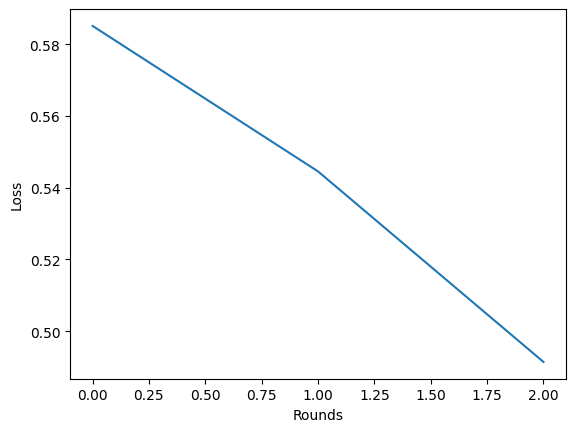

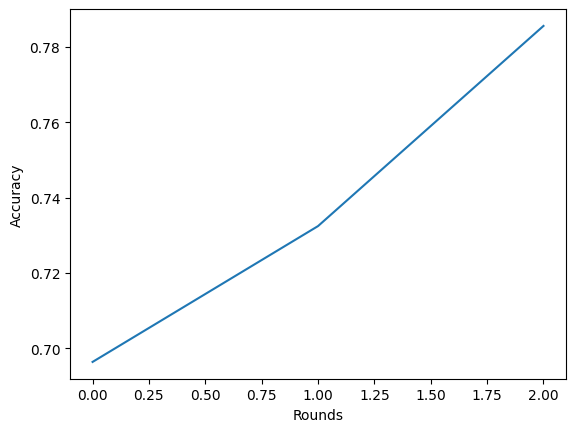

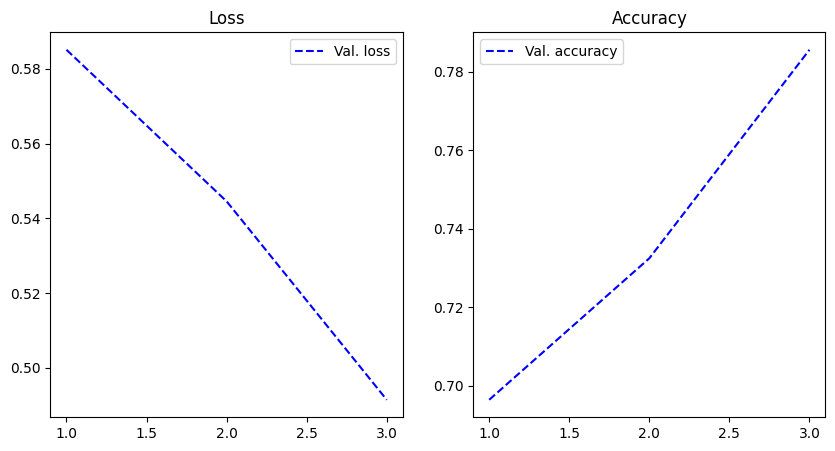

In [16]:
print("Output FL - Loss: ", output.losses_distributed)
print("Output FL - Accuracy: ", output.metrics_distributed["accuracy"])

fl_accuracy = []
fl_loss = []

for loss in output.losses_distributed:
      print(f"Loss in Round {loss[0]}: {loss[1]}")
      fl_loss.append(loss[1])
      

for acc in output.metrics_distributed["accuracy"]:
      print(f"Accuracy in Round {acc[0]}: {acc[1]}")
      fl_accuracy.append(acc[1])
      
fig = plt.figure()
ax = plt.axes()

x = range(len(fl_loss))
ax.plot(x, fl_loss)
plt.xlabel("Rounds")
plt.ylabel("Loss")

fig2 = plt.figure()
ax2 = plt.axes()

x = range(len(fl_accuracy))
ax2.plot(x, fl_accuracy)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")




# Save the plot as a PDF
result_dir = './outputs'
os.makedirs(result_dir, exist_ok=True)
DATE_NOW = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_path = os.path.join(result_dir, f'{DATE_NOW}_FL_{MODEL}_loss_accuracy_plots.pdf')
plot_loss_accuracy_FED(fl_loss, fl_accuracy, MODEL, output_path)

Centralized dataset or Federated with only one client.
Client 1
Dataset with 7909 iamges.
Trainset with 6328 iamges.
Valset with 1581 iamges.
Centralized dataset or Federated with only one client.
Client 1
Dataset with 7909 iamges.
Trainset with 6328 iamges.
Valset with 1581 iamges.
Training on cuda:0 using PyTorch 2.4.0 and Flower 1.10.0
Epoch 1/1
----------
Train Loss: 0.3488 Acc: 0.8481 (139.7128 seconds)
Val Loss: 0.1967 Acc: 0.9260 (29.8381 seconds)
Time: 170s


Training complete in 2m 50s
Best val loss: 0.1967 Best val acc: 0.9260


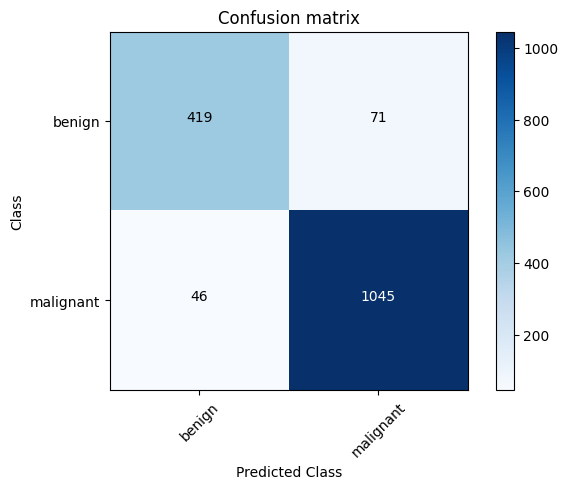

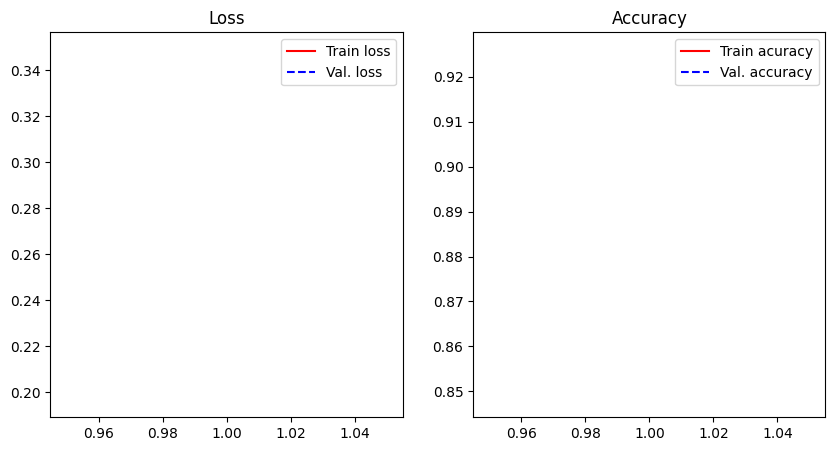

In [17]:
dataset = ImageFolder("./datasetBH")
basic_parameters = {
'num_classes' : len(dataset.classes),
'class_names': dataset.classes,
'input_size' : 224,
'batch_size' : 16,
'lr' : 0.001, # Taxa de aprendizado
'mm' : 0.9, # Momentum
'epochs' : 1,
'model_name' : "resnet", # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
'criterion' : nn.CrossEntropyLoss(), # Função de perda
'seed' : 42,
'num_clients' : 3,
'num_rounds' : 3,
}

#trainloaders, valloaders = load_data(basic_parameters, centralized=True)

#model_ft = initialize_model(basic_parameters.get('model_name'), basic_parameters.get('num_classes'))
model_ft = Net().to(DEVICE)
optimizer = optim.SGD(model_ft.parameters(), lr=basic_parameters.get('lr'), momentum=basic_parameters.get('mm'))
#optimizer = optim.Adam(model_ft.parameters(), lr=basic_parameters.get('lr'))
date_now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")



#netCentralized = Net().to(DEVICE)
trainloaders, valloaders = load_data(basic_parameters, centralized=True)
trainloader = DataLoader(ConcatDataset([ds.dataset for ds in trainloaders]), batch_size=basic_parameters.get('batch_size'), shuffle=True)
valloader = DataLoader(ConcatDataset([ds.dataset for ds in valloaders]), batch_size=basic_parameters.get('batch_size'))
dataloaders_dict = {'train': trainloader, 'val': valloader}

loss_per_epoch = []
accuracy_per_epoch = []

print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

model_ft = train_model(model_ft, dataloaders_dict, optimizer, basic_parameters, 0,date_now, DEVICE)
# for epoch in range(1000):
# 	train(netCentralized, trainloader, 1)
# 	loss, accuracy = test(netCentralized, valloader)
# 	loss_per_epoch.append(loss)
# 	accuracy_per_epoch.append(accuracy)
# 	print(f"Epoch {epoch+1}: validation loss {loss}, accuracy: {accuracy}")
# train(netCentralized, trainloader, basic_parameters.get('num_clients'), valloader, True, True)

# loss, accuracy = test(netCentralized, testloader, plot=True)
# #loss_per_epoch.append(loss)
# #accuracy_per_epoch.append(accuracy)
# print(f"Final test set performance: \n\tloss {loss} \n\taccuracy {accuracy}")
